In [1]:
# 14/01/2022 Luís

# A first version of the HGO model.

# Need to check if the function is working accordingly to literature. Then I will irove the function, for example
# by implementing different loads as a function of a string argument of the function.
# For now it only allows a uniaxial load, assuming incompressibility of the material.

# It accepts a list of parameters params = [c, κ, k1, k2, a01, a02], a01 and a02 being 3 dimensional vectors.
# This might not be the best solution, maybe it would be better for the function to accept more arguments
# instead of this list of params.

# Need to get the stretch-strain curves by generating some parameters, like in the other notebooks.

# 16/01/2022 Luís

# Corrected some bugs in the code.

# The function returns the Cauchy stress tensor (T) after imposing of BC (T = T - (I*T[2,2]), because I was
# expecting T[0,0] == T[2,2], and only T[1,1] should be different from 0.)

# I have encountered some problems now. 
# I'm still not very familiar with anisotropy, so I dont't yet get
# how can I define the F matrix for a uniaxial load if the material is anisotropic.
# Has can be seen in the examples below, both T[0,0] and T[1,1] are different from 0, after imposing the BC.

# Is the F matrix not valid? Or have I not imposed the BC correctly?

# I am yet to confirm if the function is working accordingly to litterature.

#17/01/2022 Joao
# Because we are applying homogeneous deformation modes (uniaxial, biaxial, simple shear etc,..), 
# F only depends on the external loads/displacements applied to the material. Thus,  F it's the same. 
# In a more complex BVP, the F of each material point is obtained by approximation methods. For instance, the FEM. 
#
# I made some simplifications in your code. let's start with only one family of fibres. 
# if the material has two families, we can simply add two HGO calls. 


# 19/01/2022 Luís
# Now the fibers do not resist any compression. Examples with only tensile stresses remained the same.
# Example 2 now outputs null stresses, as expected.

# 11/02/2022 Luís
# Now the HGO function accepts two strings: "uniaxial" and "equibiaxial".
# I've generated some combinations of parameters and corresponding curves for both uniaxial and equibiaxial
# loads (for now only 4 combinations, to reduce time spent in computations while implementing the code).
# I probably need to think better in the min and max values of the parameters.

#18/02/2022 Joao
# nice upgrades. =) 
#CHANGES THAT I'VE MADE: 
#max stretch = 1.6. with fibrous tissues such as arteries, usually this is the max stretch before rupture
# I have moved the generators to the top of the notebook. 
#I've slightly changed the HGO uniaxial output. now it outputs only an array of stresses. 
#when generating uniaxial, now we have two separate channels of data: stretch and stress. this has the advantage for model training.
#The idea is to generate data using pandas dataframes and use numpy arrays for model training.
#I've added an example for model training
#let me know if you were able to train the model in a separate file
#if you want to use the workstation you must run the train using a python script (not jupyter notebook)

#TODO: 
#change direction coordinates to just one angle - theta
#export generated uniaxial arrays to files              
#do the training on a separate script                    
#Train a model for uniaxial and see what happens.       
#let's forget for now equibiaxial. we already now how to handle that. if uniaxial suceeds we jump into equibiaxial
#make the uniaxial unitary examples work 



# 21/02/2022 Luís

# This notebook exists only to increase readibility and to discuss some problems. 
# I understand that curve generation and model training should be in separated files. 
# I've added two .py scripts to the repository: one for genaration and one for training.

# I've change the HGO function to accept a parameter theta instead of the direction vector a01.
# Now params = [c, κ, k1, k2, theta]

# I've generated 243 (=3^5) curves and trained the model with them.

# X and y vectors are being stored as .npy files: "X_run.npy" and "y_run.npy" at the end of the generation script.


# Problems/Questions:

# I was allways geting errors before training due to the shape of the tensors.
# To fix this I've added a tf.keras.layers.Flatten() layer to the model, but I'm not sure
# this is the correct approach. The issue was that I need the output layer to have the shape (None,5).
# I don't know if we are losing some information by flattening the tensors. 
# The model seems to train reasonably well for this number of curves, though.

# I've also added another Dense layer after flattening, but maybe it isn't essential, I have to do some tests.



# Also, at the end of this notebook, I made the initial examples work with the new theta parameter and altered HGO output.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [4]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [5]:
def double_dot(A,B):
    # Double-dot operation between two 3x3 matrices
    sum = 0
    for i in range(3):
        for j in range(3):
                sum = sum + A[i,j] * B[i,j]
    return sum


def theta_to_a01(theta):
    #defines a unit vector in the xy plane, theta degrees from the yy axis
    return [-np.sin(np.deg2rad(theta)),np.cos(np.deg2rad(theta)),0]


def HGO(params, stretch, load):
    #params = [c, κ, k1, k2, theta]
    #returns cauchy stress at yy direction if load == "uniaxial"
    #returns cauchy stress at xx and yy directions if load == "equibiaxial"
    
    if load != 'uniaxial' and load != 'equibiaxial':
        raise ValueError("Load string isn't acceptable")
    
    #3x3 Identity Matrix
    I = sym.Matrix([[1,0,0],[0,1,0],[0,0,1]])
    
    if load == "uniaxial":
        # Deformation Gradient assuming incompressibility and a uniaxial load
        F = sym.Matrix([[1/(np.sqrt(stretch)),0,0], [0,stretch,0], [0,0,1/(np.sqrt(stretch))]])
        
  #  if load == "equibiaxial":
        # Deformation Gradient assuming incompressibility and a equibiaxial load
  #      F = sym.Matrix([[stretch,0,0], [0,stretch,0], [0,0,1/(stretch**2)]])
        
    Ft=sym.transpose(F)
    Jac=sym.det(F)
    
    # Modified Deformation Gradient
    Fm = Jac**(-1/3) * I * F
    Fmt=sym.transpose(Fm)
    
    # Modified Right Cauchy-Green Deformation Tensor with values according to F: 'Cmv'
    Cmv=Fmt*Fm

    # Symbolic Modified Right Cauchy-Green Deformation Tensor 'Cm'
    Cm11 = sym.Symbol('Cm11')
    Cm12 = sym.Symbol('Cm12')
    Cm13 = sym.Symbol('Cm13')
    Cm21 = sym.Symbol('Cm21')
    Cm22 = sym.Symbol('Cm22')
    Cm23 = sym.Symbol('Cm23')
    Cm31 = sym.Symbol('Cm31')
    Cm32 = sym.Symbol('Cm32')
    Cm33 = sym.Symbol('Cm33')
    Cm = sym.Matrix([[Cm11,Cm12,Cm13], [Cm21,Cm22,Cm23], [Cm31,Cm32,Cm33]])  
    
    # Compute the invariant im1  of the tensor Cm
    im1=sym.trace(Cm)
    
    #symbolic Neo-Hookean parameter c
    c = sym.Symbol('c')
    
    # symbolic dispersion parameter κ (0 < κ < 1/3) (the symbol is the greek letter 'kappa')
    κ = sym.Symbol('κ')
    
    # symbolic material parameters k1 and k2 (k1>0; k2>0)
    k1=sym.Symbol('k1')
    k2=sym.Symbol('k2')
    
    # Unit vector representing the direction of the fibres in the stress free configuration
    # params[4] = angle theta between the mean orientation of the fibers and the yy axis.
    a01_list = theta_to_a01(params[4])
    a01 = sym.Matrix(a01_list)
    
    # Structure Tensors H1, which depend on κ and a01
    
    if double_dot(Cmv, TensorProduct(a01,sym.transpose(a01))) > 1:   # condition to only allow tensile stress
        H1 = κ*I + (1-3*κ)*(TensorProduct(a01,sym.transpose(a01)))
    else:
        H1 = κ*I
        
    E1 = double_dot(H1,Cm) - 1
    
    #alternative: for debbugging 
    #m0 =TensorProduct(a01,sym.transpose(a01))
    #im4 = double_dot(Cm,m0) #pseudo-invariant 4. very important measure. it tells us the squared stretch of the fibers
    #E1 = im4*(1-3*κ) + κ*im1-1
    
    #Generate SEF (Strain Energy Function)
    sef= 0.5 * c * (im1 - 3) + (k1/(2*k2)) * (sym.exp(k2*E1*E1) - 1)
    
    #Second Piola Kirchoff Stresses
    S11=2*sym.diff(sef,Cm11)
    S12=2*sym.diff(sef,Cm12)
    S13=2*sym.diff(sef,Cm13)
    S21=2*sym.diff(sef,Cm21)
    S22=2*sym.diff(sef,Cm22)
    S23=2*sym.diff(sef,Cm23)
    S31=2*sym.diff(sef,Cm31)
    S32=2*sym.diff(sef,Cm32)
    S33=2*sym.diff(sef,Cm33)
    S = sym.Matrix([[S11,S12,S13], [S21,S22,S23], [S31,S32,S33]])
    
    
    T = (1/Jac)*(F*S*Ft) # cauchy stresses with no BCs
    T = T - (I*T[2,2]) # imposing of boundary conditions
    
    T=T.subs([(Cm11, Cmv[0,0]), (Cm12, Cmv[0,1]), 
                                  (Cm13, Cmv[0,2]),(Cm21, Cmv[1,0]), 
                                  (Cm22, Cmv[1,1]), (Cm23, Cmv[1,2]),
                                  (Cm31, Cmv[2,0]), (Cm32, Cmv[2,1]), 
                                  (Cm33, Cmv[2,2]),(c,params[0]), 
                                  (κ,params[1]),(k1,params[2]),(k2,params[3])])
    
    if load == 'uniaxial':
        return T[1,1]

#    if load == 'equibiaxial':
#        return stretch, [T[0,0],T[1,1]]

def get_curve(params, stretch_min, stretch_max, ninc, load):
    #stores HGO loading runs between a minimum and a maximum stretch
    
    if load == "uniaxial":
        stretches=np.linspace(stretch_min,stretch_max,ninc)
        stresses=[HGO(params, stretch, load) for stretch in stretches]
        return np.asarray(stresses)
#    if load == "equibiaxial":
#        lst_xx=[[stretch,HGO(params, stretch, load)[1][0]] for stretch in np.linspace(stretch_min,stretch_max,ninc)]
#        lst_yy=[[stretch,HGO(params, stretch, load)[1][1]] for stretch in np.linspace(stretch_min,stretch_max,ninc)]
#        return lst_xx, lst_yy

In [6]:
#Initial data-----------------------------------------------------------------------------------------------------

c_min = 1.0
c_max = 40.0
n_c = 3

κ_min = 0.0
κ_max = 1/3
n_κ = 3

k1_min = 0.1
k1_max = 5.0
n_k1 = 3

k2_min = 0.1
k2_max = 5.0
n_k2 = 3

θ_min = 0 # in degrees
θ_max = 90 # in degrees
n_θ = 2

decimals=2   #number of decimal cases for each parameter value

n = n_c * n_κ * n_k1 * n_k2 * n_θ # total combinations

st_max=1.6            # applied stretch
st_min=1.0
ninc=10        # number of stretch increments

#parameters grid
c_list = np.round(np.random.uniform(c_min, c_max, size = n_c), decimals)
κ_list = np.round(np.random.uniform(κ_min, κ_max, size=n_κ), decimals)
k1_list = np.round(np.random.uniform(k1_min, k1_max, size=n_k1), decimals)
k2_list = np.round(np.random.uniform(k2_min, k2_max, size=n_k2), decimals)
θ_list = np.round(np.random.uniform(θ_min, θ_max, size=n_θ), decimals)

# Computes the n combinations of params

params = []

for i in c_list:
    for j in κ_list:
        for k in k1_list:
            for l in k2_list:
                for m in θ_list:
                    params.append([i,j,k,l,m])

params = np.array(params, dtype = object)
params = params.reshape(-1, 5)
np.random.shuffle(params)

# Append the combinations to a DataFrame
df = pd.DataFrame(params[:,0], columns = ['c'])
df['κ'] = params[:,1]
df['k1'] = params[:,2]
df['k2'] = params[:,3]
df['θ'] = params[:,4]

df

,c,κ,k1,k2,θ
0,13.21,0.12,1.76,1.71,86.44
1,35.59,0.3,0.35,1.71,86.44
2,35.59,0.3,1.95,2.59,86.44
3,13.21,0.3,1.76,1.71,63.77
4,35.59,0.3,1.76,2.59,86.44
5,6.05,0.12,1.76,2.59,63.77
6,6.05,0.12,0.35,2.59,86.44
7,35.59,0.07,1.76,2.59,86.44
8,13.21,0.3,0.35,2.59,63.77
9,35.59,0.3,1.95,1.71,86.44


In [7]:
#generate uniaxial
#generate (x,y) data for each unique combination of params at the dataframe, for a uniaxial load
load = "uniaxial"
df_uniaxial = df.copy()
df_uniaxial['stretch']=df.apply(lambda x : np.linspace(st_min,st_max,ninc), axis=1)
df_uniaxial['stress']=df.apply(lambda x : get_curve(x,st_min,st_max,ninc, load), axis=1)

df_uniaxial

,c,κ,k1,k2,θ,stretch,stress
0,13.21,0.12,1.76,1.71,86.44,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[1.06227702951014e-18, 2.53722035999747, 5.097..."
1,35.59,0.3,0.35,1.71,86.44,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[3.30075426428059e-20, 7.12377703098706, 14.30..."
2,35.59,0.3,1.95,2.59,86.44,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[1.83899166152775e-19, 7.10480559159211, 14.26..."
3,13.21,0.3,1.76,1.71,63.77,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[0, 2.62500664153498, 5.27497605559530, 7.9701..."
4,35.59,0.3,1.76,2.59,86.44,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[1.65980785860967e-19, 7.10705446272473, 14.27..."
5,6.05,0.12,1.76,2.59,63.77,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[0, 1.05643567925388, 2.12752523538399, 3.2251..."
6,6.05,0.12,0.35,2.59,86.44,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[2.11248272913948e-19, 1.18080799492738, 2.371..."
7,35.59,0.07,1.76,2.59,86.44,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[1.31124820830157e-18, 6.93253238645182, 13.92..."
8,13.21,0.3,0.35,2.59,63.77,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[0, 2.64152678709488, 5.30429309790894, 8.0052..."
9,35.59,0.3,1.95,1.71,86.44,"[1.0, 1.0666666666666667, 1.1333333333333333, ...","[1.83899166152775e-19, 7.10499266470573, 14.26..."


In [8]:
#get number of samples
nsamples=df_uniaxial.shape[0]
#get data channels. in this case, stretch and stress
channels = ['stretch','stress']
#number of channels
nchannels=len(channels)
#number of data points
npts=ninc
# data array
y=np.empty((nsamples,npts,nchannels))

for idx,signal in enumerate(channels):
    #convert signal to numpy
    s=df_uniaxial[signal].to_numpy()
    #flatten
    s=np.concatenate(s)
    #flatten then reshape ()
    s=s.reshape(df_uniaxial[signal].shape[0],npts)
    #append to data array
    y[:,:,idx] = s

#working with X like this will be easier to handle tensor shapes during model training 
#X = np.asarray(X).astype('float32')
#X=np.asarray(X.tolist())
print(nsamples,npts,nchannels)
#len(channels)

162 10 2


In [9]:
#features, i.e., material parameters
#features
features = ['c','κ','k1','k2','θ'] #I won't include "a0" because it will be replaced by an angle. add that later
nfeatures=len(features)
# features array
X=np.empty((nsamples,nfeatures))

for idx,signal in enumerate(features):
    #convert signal to numpy
    s=df_uniaxial[signal].to_numpy()
    #append to features array
    X[:,idx] = s #double check if it has the correct shape
#y=df1.ehertz.to_numpy()
#y=np.asarray(y.tolist())

#export X and y to approriate files.

In [10]:
print("X shape: ", np.shape(X))
print('\n')
print("y shape: ", np.shape(y))
print('\n')
print(X[0])
print('\n')
print(y[0])

X shape:  (162, 5)


y shape:  (162, 10, 2)


[13.21  0.12  1.76  1.71 86.44]


[[1.00000000e+00 1.06227703e-18]
 [1.06666667e+00 2.53722036e+00]
 [1.13333333e+00 5.09743147e+00]
 [1.20000000e+00 7.69913154e+00]
 [1.26666667e+00 1.03569962e+01]
 [1.33333333e+00 1.30827486e+01]
 [1.40000000e+00 1.58857922e+01]
 [1.46666667e+00 1.87736830e+01]
 [1.53333333e+00 2.17524916e+01]
 [1.60000000e+00 2.48270878e+01]]


In [11]:
#np.save('X_run', X)
#np.save('y_run', y)

Here we transition from one script to the other

In [12]:
#X = np.load('X_run.npy')
#y = np.load('y_run.npy')

In [13]:
#the code below should be in a separate file. it's is important to keep data generator separated from model training

#training script should start by loading X and y

#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1
x_train, x_test,y_train,y_test = train_test_split(X, y, test_size = test_split)
#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
print('Training set: ',y_train.shape)
print('Test set: ',y_test.shape)
#train_size = train_df.shape[0]
#test_size = test_df.shape[0]

#reshape for keras training
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 2))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 2))
#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


Input data
Training set:  (145, 5)
Test set:  (17, 5)
 
Features
Training set:  (145, 10, 2)
Test set:  (17, 10, 2)


In [14]:
np.shape(x_train)

(145, 5)

In [15]:
np.shape(y_train)

(145, 10, 2)

In [39]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EPOCHS = 200
INPUT_SHAPE = x_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1:]


inputs = keras.Input(shape=INPUT_SHAPE)

dense = layers.Dense(16 * ninc, activation="relu")
x = dense(inputs)

dense = layers.Dense(32 * ninc, activation="relu")
x = dense(x)

x = tf.keras.layers.Reshape((ninc, -1))(x)

x = layers.Dense(16, activation="relu")(x)

dropout = tf.keras.layers.Dropout(0.2)
x = dropout(x)

outputs = layers.Dense(2)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["mean_squared_error"],
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 160)               960       
_________________________________________________________________
dense_9 (Dense)              (None, 320)               51520     
_________________________________________________________________
reshape_2 (Reshape)          (None, 10, 32)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 10, 16)            528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 10, 2)             34    

In [40]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

Epoch 1/200
2/2 [==============================] - 1s 248ms/step - loss: 252.2473 - mean_squared_error: 252.2473 - val_loss: 326.8882 - val_mean_squared_error: 326.8882
Epoch 2/200
2/2 [==============================] - 0s 54ms/step - loss: 223.2951 - mean_squared_error: 223.2951 - val_loss: 293.5308 - val_mean_squared_error: 293.5308
Epoch 3/200
2/2 [==============================] - 0s 53ms/step - loss: 204.0847 - mean_squared_error: 204.0847 - val_loss: 266.8590 - val_mean_squared_error: 266.8590
Epoch 4/200
2/2 [==============================] - 0s 49ms/step - loss: 184.3259 - mean_squared_error: 184.3259 - val_loss: 243.5984 - val_mean_squared_error: 243.5984
Epoch 5/200
2/2 [==============================] - 0s 54ms/step - loss: 170.4916 - mean_squared_error: 170.4916 - val_loss: 222.0343 - val_mean_squared_error: 222.0343
Epoch 6/200
2/2 [==============================] - 0s 55ms/step - loss: 159.9209 - mean_squared_error: 159.9209 - val_loss: 202.1591 - val_mean_squared_error: 

2/2 [==============================] - 0s 61ms/step - loss: 29.0335 - mean_squared_error: 29.0335 - val_loss: 12.9548 - val_mean_squared_error: 12.9548
Epoch 51/200
2/2 [==============================] - 0s 57ms/step - loss: 30.7981 - mean_squared_error: 30.7981 - val_loss: 11.7284 - val_mean_squared_error: 11.7284
Epoch 52/200
2/2 [==============================] - 0s 42ms/step - loss: 30.2994 - mean_squared_error: 30.2994 - val_loss: 10.6115 - val_mean_squared_error: 10.6115
Epoch 53/200
2/2 [==============================] - 0s 39ms/step - loss: 25.3847 - mean_squared_error: 25.3847 - val_loss: 9.6052 - val_mean_squared_error: 9.6052
Epoch 54/200
2/2 [==============================] - 0s 49ms/step - loss: 27.3878 - mean_squared_error: 27.3878 - val_loss: 8.8759 - val_mean_squared_error: 8.8759
Epoch 55/200
2/2 [==============================] - 0s 52ms/step - loss: 24.2326 - mean_squared_error: 24.2326 - val_loss: 8.2598 - val_mean_squared_error: 8.2598
Epoch 56/200
2/2 [===========

2/2 [==============================] - 0s 45ms/step - loss: 18.6915 - mean_squared_error: 18.6915 - val_loss: 2.6062 - val_mean_squared_error: 2.6062
Epoch 101/200
2/2 [==============================] - 0s 54ms/step - loss: 17.0528 - mean_squared_error: 17.0528 - val_loss: 2.4541 - val_mean_squared_error: 2.4541
Epoch 102/200
2/2 [==============================] - 0s 51ms/step - loss: 20.9962 - mean_squared_error: 20.9962 - val_loss: 2.4798 - val_mean_squared_error: 2.4798
Epoch 103/200
2/2 [==============================] - 0s 55ms/step - loss: 20.6483 - mean_squared_error: 20.6483 - val_loss: 2.4792 - val_mean_squared_error: 2.4792
Epoch 104/200
2/2 [==============================] - 0s 51ms/step - loss: 17.8390 - mean_squared_error: 17.8390 - val_loss: 2.3998 - val_mean_squared_error: 2.3998
Epoch 105/200
2/2 [==============================] - 0s 54ms/step - loss: 17.7527 - mean_squared_error: 17.7526 - val_loss: 2.4467 - val_mean_squared_error: 2.4467
Epoch 106/200
1/1 [===========

291.1753008365631


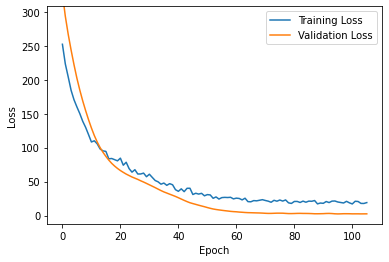

In [41]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

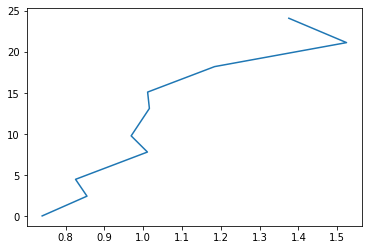

In [42]:
x_predict = np.zeros(ninc)
y_predict = np.zeros(ninc)

c = 0
for i in model.predict(x_test[0:1])[0]:
    x_predict[c] = i[0]
    y_predict[c] = i[1]
    c = c+1
    
plt.plot(x_predict,y_predict)

In [43]:
x_true = np.zeros(ninc)
y_true = np.zeros(ninc)

c = 0
for i in y_test[0:1][0]:
    x_true[c] = i[0]
    y_true[c] = i[1]
    c = c+1

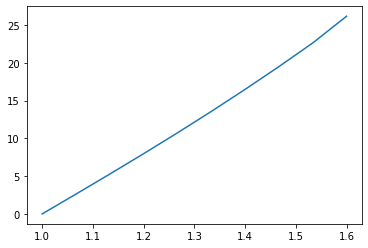

In [44]:
plt.plot(x_true,y_true)

HGO Initial examples

In [29]:
# Example 1
# evaluated for unitary parameters. no dispersion

c= 1 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented along the pulling direction
theta = 0
#a01 = [-np.sin(np.deg2rad(90)),np.cos(np.deg2rad(0)),0]


params = [c, κ, k1, k2, theta]
stretch = 1.2
load = "uniaxial"

stress = HGO(params, stretch, load)

stress # in kPa

2.14455419836872

In [30]:
# Example 2
#evaluated for unitary parameters. no dispersion

c= 0 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented transversal to the pulling direction
theta = 90


params = [c, κ, k1, k2, theta]
stretch = 1.2
load = "uniaxial"

stress = HGO(params, stretch, load)

stress # in pressure units

0

In [31]:
# Example 3
# κ = 1/3, which means that the material is isotropic, i.e. Neo Hooke material.

c= 1 # pressure units
κ = 1/3
k1 = 1.0 # pressure units
k2 = 1.0
theta = 65


params = [c, κ, k1, k2, theta]
stretch = 1.2
load = "uniaxial"

stress = HGO(params, stretch, load)

stress # in pressure units

0.621065104548954

In [32]:
# Example 4
# κ = 0.1, arbitrary orientation. 


c= 1.0 # pressure units
κ = 0.1
k1 = 1.0 # pressure units
k2 = 1.0
theta = 65


params = [c, κ, k1, k2, theta]
stretch = 1.2
load = "uniaxial"

stress = HGO(params, stretch, load)

stress  # in pressure units

0.472149517852544

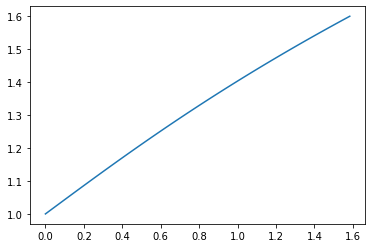

In [33]:
check = np.array(get_curve(params,1.0,1.6,50,"uniaxial"))
plt.plot(check,np.linspace(1.0,1.6,50))